Model for prediction a price of tutors' servecices in Moscow
---
Site: repetit.ru

City: Moscow

In [1]:
pip install fuzzywuzzy

In [2]:
import pandas as pd
import re
import numpy as np
from ast import literal_eval
import fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
tutors_data = pd.read_csv('/content/tutors_eng_2021_10_06.csv')

In [4]:
tutors_data.shape

(88699, 12)

In [5]:
tutors_data.head()

,Categories,Price,Score,Format,Reviews_number,Experience,Status,Location,Tags,Audience,Video_presentation,Photo
0,"['German', 'Spanish']",1800,5.0,['remotely'],26.0,21.0,Private tutor,NaN,NaN,NaN,NaN,NaN
1,['Mathematics'],2500,4.9,"['at the tutor's', 'remotely']",41.0,29.0,Private tutor,['metro Schukinskaja'],"['ОГЭ (ГИА)', 'ЕГЭ', 'подготовка к олимпиадам'...","['Pupils of 4-11 grades', 'Students']",No,Yes
2,['English'],1500,5.0,"['at the tutor's', 'at the student's', 'remote...",14.0,11.0,Private tutor,['metro Chertanovskaja'],"['ОГЭ (ГИА)', 'ЕГЭ', 'подготовка к олимпиадам'...","['Children 6-7 years old', 'Pupils of 1-11 gra...",Yes,Yes
3,['Chemistry'],1300,5.0,['remotely'],41.0,39.0,Private tutor,NaN,NaN,NaN,NaN,NaN
4,['Mathematics'],1500,5.0,"['at the tutor's', 'at the student's', 'remote...",35.0,9.0,School teacher,"['metro Otradnoe', 'metro Babushkinskaja', 'me...","['ОГЭ (ГИА)', 'ЕГЭ', ' школьный курс', 'Алгебр...",['Pupils of 5-11 grades'],No,Yes


Features description:

*   **Categories** - Lists of taught subjects out of 27 subjects
*   **Price** - Price in rub per hour
*   **Score** - Average score based on the reviews, 0.0-5.0
*   **Format** - Lists of working formats. Options: remotely, at the tutor's place, at the student's place
*   **Reviews_number** - Amount of student's reviews in the tutor's profile
*   **Experience** - Experience in years
*   **Status** - Current tutor's status. Options: Private tutor, School teacher, Postgraduate student, Native speaker, University professor, Student, not stated (missing)
*   **Location** - Metro stations or cities in Moscow region
*   **Tags** - Tutor's services. They are stated by tutors and can differs. They are remained in Russian in the dataset
*   **Audience** - Tutor's target audience. For example: students, pupils of 10 grades etc. They are stated by tutors and can differs
*   **Video_presentation** - Video presentation availability
*   **Photo** - Profile photo availability

Dataset Analysis
---

In [6]:
tutors_data.isnull().sum()

Categories                0
Price                     0
Score                     0
Format                    0
Reviews_number        63174
Experience            63174
Status                63174
Location              65406
Tags                  65419
Audience              65420
Video_presentation    65420
Photo                 65420
dtype: int64

Almost 74 % of the data is missing or empty for 8 last columns. Let's look at the missing rows closely.

In [7]:
cols_with_missings = ['Reviews_number', 'Experience', 'Status', 'Location', 'Tags', 'Audience', 'Video_presentation', 'Photo']
null_data = tutors_data[tutors_data.isnull().any(axis=1)]
null_data

,Categories,Price,Score,Format,Reviews_number,Experience,Status,Location,Tags,Audience,Video_presentation,Photo
0,"['German', 'Spanish']",1800,5.0,['remotely'],26.0,21.0,Private tutor,NaN,NaN,NaN,NaN,NaN
3,['Chemistry'],1300,5.0,['remotely'],41.0,39.0,Private tutor,NaN,NaN,NaN,NaN,NaN
7,['English'],6000,5.0,['remotely'],23.0,17.0,Native speaker,NaN,NaN,NaN,NaN,NaN
16,['English'],1000,4.8,['remotely'],9.0,7.0,Private tutor,NaN,NaN,NaN,NaN,NaN
19,"['Japanese', 'Russian as a foreign language']",1400,5.0,['remotely'],41.0,14.0,Private tutor,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
88692,"['Physics', 'Rare foreign languages']",350,4.3,['remotely'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88694,"['Sport and fitness', 'Other']",1800,4.3,"['at the tutor's', 'at the student's']",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88696,"['Preschooler activities', 'Elementary School']",700,4.3,['at the student's'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88697,['French'],1500,4.3,['at the student's'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
null_data['Format'] = null_data['Format'].apply(lambda s: str(s).replace("at the tutor's","tutors place"))
null_data['Format'] = null_data['Format'].apply(lambda s: str(s).replace("at the student's","students place"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
for i in ['Categories', 'Format']:
    null_data[i] = null_data[i].apply(lambda s: list(literal_eval(str(s))) if s != np.nan else s)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
null_expl = null_data.explode('Format')
null_expl

,Categories,Price,Score,Format,Reviews_number,Experience,Status,Location,Tags,Audience,Video_presentation,Photo
0,"[German, Spanish]",1800,5.0,remotely,26.0,21.0,Private tutor,NaN,NaN,NaN,NaN,NaN
3,[Chemistry],1300,5.0,remotely,41.0,39.0,Private tutor,NaN,NaN,NaN,NaN,NaN
7,[English],6000,5.0,remotely,23.0,17.0,Native speaker,NaN,NaN,NaN,NaN,NaN
16,[English],1000,4.8,remotely,9.0,7.0,Private tutor,NaN,NaN,NaN,NaN,NaN
19,"[Japanese, Russian as a foreign language]",1400,5.0,remotely,41.0,14.0,Private tutor,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
88694,"[Sport and fitness, Other]",1800,4.3,students place,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88696,"[Preschooler activities, Elementary School]",700,4.3,students place,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88697,[French],1500,4.3,students place,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88698,"[English, Italian]",1000,4.3,students place,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Columns:

    
*   **`Reviews_number`**: There was no data on the page during parsing, so we can claim that these tutors don't have reviews from the students at all, although they have the score. We can fill in 0 for the missings.
*   **`Experience`**: Tutors didn't indicate their experience, so we can assume that they don't have any or have little. Let's fill in 0 for the missings values.
*   **`Status`**: Tutors didn't stated their status. We'll fill the missings with '`-`' that means '`No status`'.
*   **`Location`**: 75 % of the missings have `remote` format of working. Let's assume the rest of the tutors are very mobile and can reach any place of Moscow easily (Heh, I'd look at it). So we'll fill in the missing cells with value '`[]`' denoting all the location of Moscow.
*   **`Tags`**: The tags are written by the tutors and have lots of different values. We won't use this feature for prediction. Just fill in with '`[]`'.
*   **`Audience`**: Assume that the tutors work with all the kind of audience, so fill in with '`[All]`'.
*   **`Video_presentation`** and **`Photo`**: There was no data about these parameters on parsed pages, so we'll fill in the missings with '`No`'.

In [11]:
null_expl.Format.value_counts()

remotely          49019
students place    44137
tutors place      29637
Name: Format, dtype: int64

In [12]:
49019 / 65420 * 100

74.92968511158668

Data preprocessing and more analysis
---
Let's start filling in the missings

In [13]:
tutors_data_preprocessed = tutors_data.copy()

In [14]:
tutors_data_preprocessed[['Reviews_number', 'Experience']] = tutors_data_preprocessed[['Reviews_number', 'Experience']].fillna(0)
tutors_data_preprocessed['Status'] = tutors_data_preprocessed['Status'].fillna('-')
tutors_data_preprocessed[['Location', 'Tags']] = tutors_data_preprocessed[['Location', 'Tags']].fillna('[]')
tutors_data_preprocessed['Audience'] = tutors_data_preprocessed['Audience'].fillna('[\'All\']')
tutors_data_preprocessed[['Video_presentation', 'Photo']] = tutors_data_preprocessed[['Video_presentation', 'Photo']].fillna('No')

In [15]:
tutors_data_preprocessed.isnull().sum().sum()

0

After reading from the csv file the data contains lists as strings. For the further analysis we need to convert the values to lists.

In [16]:
cols_with_lists = ['Categories', 'Format', 'Location', 'Tags', 'Audience']

In [17]:
tutors_data_preprocessed['Format'] = tutors_data_preprocessed['Format'].apply(lambda s: str(s).replace("at the tutor\'s", "tutors place"))
tutors_data_preprocessed['Format'] = tutors_data_preprocessed['Format'].apply(lambda s: str(s).replace("at the student\'s", "students place"))
tutors_data_preprocessed['Location'] = tutors_data_preprocessed['Location'].apply(lambda s: str(s).replace("[\'", '[\"'))
tutors_data_preprocessed['Location'] = tutors_data_preprocessed['Location'].apply(lambda s: str(s).replace("\']", '\"]'))
tutors_data_preprocessed['Location'] = tutors_data_preprocessed['Location'].apply(lambda s: str(s).replace("\', \'", '\", \"'))

In [18]:
for i in cols_with_lists:
    tutors_data_preprocessed[i] = tutors_data_preprocessed[i].apply(lambda s: list(literal_eval(str(s))) if s != np.nan else s)

In [19]:
type(tutors_data_preprocessed.loc[0, 'Format'])

list

In [20]:
tutors_data_preprocessed.head()

,Categories,Price,Score,Format,Reviews_number,Experience,Status,Location,Tags,Audience,Video_presentation,Photo
0,"[German, Spanish]",1800,5.0,[remotely],26.0,21.0,Private tutor,[],[],[All],No,No
1,[Mathematics],2500,4.9,"[tutors place, remotely]",41.0,29.0,Private tutor,[metro Schukinskaja],"[ОГЭ (ГИА), ЕГЭ, подготовка к олимпиадам, шко...","[Pupils of 4-11 grades, Students]",No,Yes
2,[English],1500,5.0,"[tutors place, students place, remotely]",14.0,11.0,Private tutor,[metro Chertanovskaja],"[ОГЭ (ГИА), ЕГЭ, подготовка к олимпиадам, FCE,...","[Children 6-7 years old, Pupils of 1-11 grades...",Yes,Yes
3,[Chemistry],1300,5.0,[remotely],41.0,39.0,Private tutor,[],[],[All],No,No
4,[Mathematics],1500,5.0,"[tutors place, students place, remotely]",35.0,9.0,School teacher,"[metro Otradnoe, metro Babushkinskaja, metro S...","[ОГЭ (ГИА), ЕГЭ, школьный курс, Алгебра, Геом...",[Pupils of 5-11 grades],No,Yes


Let's apply one-hot encoding for '**`Categories`**', '**`Format`**' and '**`Audience`**'.

In [21]:
categories_series = tutors_data_preprocessed['Categories'].explode()
categories_series.unique()

array(['German', 'Spanish', 'Mathematics', 'English', 'Chemistry',
       'Physics', 'Russian', 'Literature', 'Social studies', 'History',
       'Music', 'Russian as a foreign language', 'Geography', 'Other',
       'Biology', 'Japanese', 'Rare foreign languages',
       'Elementary School', 'Informatics / Programming', 'Art', 'French',
       'Preschooler activities', 'Speech therapist', 'Economics',
       'Italian', 'Sport and fitness', 'Chinese'], dtype=object)

In [22]:
tutors_data_preprocessed = tutors_data_preprocessed.join(pd.crosstab(categories_series.index, categories_series))

In [23]:
categories_list = tutors_data_preprocessed.columns[12:39]
categories_popularity = tutors_data_preprocessed[categories_list].sum().sort_values(ascending=False)
categories_popularity

English                          31930
Mathematics                      18629
Russian                          11751
Music                             6729
Physics                           6001
Social studies                    5453
Elementary School                 5316
History                           5047
Chemistry                         4805
Other                             4726
Preschooler activities            4165
Literature                        4039
German                            4019
French                            3923
Biology                           3538
Informatics / Programming         3488
Russian as a foreign language     2611
Spanish                           2409
Rare foreign languages            2261
Art                               2080
Chinese                           2019
Sport and fitness                 1169
Italian                           1002
Speech therapist                   999
Geography                          939
Economics                

The most popular category for tutoring is 'English' - 31 390 tutors on '*repetit.ru*'. The second is 'Mathematics' - 18 629 tutors. And the third is 'Russian' - 11 751 tutors. Does the current generation of russian kids have problems with the native language? Not necessarily, they just prepare for the compulsory exam 'ЕГЭ' (The Unified State Exam, Russian: Единый государственный экзамен, ЕГЭ, Yediniy gosudarstvenniy ekzamen, EGE). Not surprising. let's move on.

In [24]:
format_series = tutors_data_preprocessed['Format'].explode()
format_series.unique()

array(['remotely', 'tutors place', 'students place'], dtype=object)

In [25]:
tutors_data_preprocessed = tutors_data_preprocessed.join(pd.crosstab(format_series.index, format_series))

Now let's look closely at the '**`Audience`**'. We have lots of similar entries here so we need to shorten the list of unique variables. We'll divide this huge amount of similar variables into the following general groups:

*   All
*   Adults
*   Students
*   Pupils of 10-11 grades (Russian schools have 11 grades)
*   Pupils of 5-9 grades
*   Pupils of 1-4 grades
*   Children 6-7 years old
*   Children 4-5 years old
*   Children 1-3 years old

In [26]:
audience_series = tutors_data_preprocessed['Audience'].explode()
audience_list = audience_series.unique()
audience_list

array(['All', 'Pupils of 4-11 grades', 'Students',
       'Children 6-7 years old', 'Pupils of 1-11 grades', 'Adults',
       'Pupils of 5-11 grades', 'Pupils of 7-11 grades',
       'Children 1-3 года', 'Children 4-5 years old',
       'Pupils of 6-11 grades', 'Pupils of 8-11 grades',
       'Pupils of 3-8 grades', 'Pupils of 9-11 grades',
       'Pupils of 2-11 grades', 'Pupils of 10-11 grades',
       'Pupils of 3-11 grades', 'Pupils of 2-9 grades',
       'Pupils of 5-9 grades', 'Pupils of 1-9 grades',
       'Pupils of 7-9 grades', 'Pupils of 3-9 grades',
       'Pupils of 11 grade', 'Pupils of 2-4 grades',
       'Pupils of 1-8 grades', 'Pupils of 1-5 grades', 'Pupils of 5-8',
       '10 grades', 'Pupils of 6-10 grades', 'Pupils of 1-10 grades',
       'Pupils of 1-4 grades', 'Pupils of 1-6 grades',
       'Pupils of 4-10 grades', 'Pupils of 5-10 grades',
       'Pupils of 3-10 grades', 'Pupils of 4-9 grades',
       'Pupils of 2-8 grades', 'Pupils of 2', '9-11 grades',
       'P

Function to replace rows in the data with similar values

In [27]:
def replace_matches_in_column(df, col, string_to_match, replacing, min_ratio = 50):
    exploded_df = df.explode(column=col)
    strings = exploded_df[col].unique()
    
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=30, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]
    rows_with_matches = exploded_df[col].isin(close_matches)


    exploded_df.loc[rows_with_matches] = replacing
    imploded_column = exploded_df.groupby(exploded_df.index).agg({col: lambda x: x.tolist()})
    df[col] = imploded_column

Replacing

In [28]:
for i in ['11', '10']:
    replace_matches_in_column(df=tutors_data_preprocessed, col='Audience', string_to_match=i, replacing='Pupils of 10-11 grades', min_ratio=17)
for i in ['9', '8', '7', '6', '5']:
    replace_matches_in_column(df=tutors_data_preprocessed, col='Audience', string_to_match=i, replacing='Pupils of 5-9 grades', min_ratio=10)
replace_matches_in_column(df=tutors_data_preprocessed, col='Audience', string_to_match='4', replacing='Pupils of 1-4 grades', min_ratio=10)
for i in ['3', '2']:
    replace_matches_in_column(df=tutors_data_preprocessed, col='Audience', string_to_match='Pupils of ' + i, replacing='Pupils of 1-4 grades', min_ratio=71)
replace_matches_in_column(df=tutors_data_preprocessed, col='Audience', string_to_match='Children 1-3 года', replacing='Children 1-3 years old', min_ratio=100)

Check '**`Audience`**'

In [29]:
audience_series = tutors_data_preprocessed['Audience'].explode()
audience_list = audience_series.unique()
audience_list

array(['All', 'Pupils of 10-11 grades', 'Students',
       'Children 6-7 years old', 'Adults', 'Children 1-3 years old',
       'Children 4-5 years old', 'Pupils of 5-9 grades',
       'Pupils of 1-4 grades'], dtype=object)

In [30]:
tutors_data_preprocessed = tutors_data_preprocessed.join(pd.crosstab(audience_series.index, audience_series))

Look at the **`'Location'`**

In [31]:
tutors_data_preprocessed['Location'].explode().value_counts()

metro Universitet          412
metro Jugo-Zapadnaja       410
Leninskij rajon            393
metro Akademicheskaja      374
Tsentral'nyj rajon         347
                          ... 
city Gukovo                  1
Nagornyj rajon               1
metro Horoshevskaja(BK)      1
city Aleksin                 1
city Semikarakorsk           1
Name: Location, Length: 800, dtype: int64

Let's drop encoded features with lists. We are also dropping unencoded '**`Location`**' due to covid situation because most people will prefer to work remotely in order not to get infected.

In [32]:
tutors_data_preprocessed = tutors_data_preprocessed.drop(cols_with_lists, axis=1)

In [33]:
tutors_data_preprocessed.head()

,Price,Score,Reviews_number,Experience,Status,Video_presentation,Photo,Art,Biology,Chemistry,Chinese,Economics,Elementary School,English,French,Geography,German,History,Informatics / Programming,Italian,Japanese,Literature,Mathematics,Music,Other,Physics,Preschooler activities,Rare foreign languages,Russian,Russian as a foreign language,Social studies,Spanish,Speech therapist,Sport and fitness,remotely,students place,tutors place,Adults,All,Children 1-3 years old,Children 4-5 years old,Children 6-7 years old,Pupils of 1-4 grades,Pupils of 10-11 grades,Pupils of 5-9 grades,Students
0,1800,5.0,26.0,21.0,Private tutor,No,No,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1,2500,4.9,41.0,29.0,Private tutor,No,Yes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1
2,1500,5.0,14.0,11.0,Private tutor,Yes,Yes,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,1,0,1
3,1300,5.0,41.0,39.0,Private tutor,No,No,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4,1500,5.0,35.0,9.0,School teacher,No,Yes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0


It only remains to encode '**`Status`**', '**`Video_presentation`**' and '**`Photo`**' columns.

In [34]:
status_coding = {'Private tutor': '4', 'School teacher': '2', 'Postgraduate student': '3',
       'Native speaker': '6', 'University professor': '5', 'Student': '1', '-': '0'}

In [35]:
for elem in status_coding:
    tutors_data_preprocessed['Status'] = tutors_data_preprocessed['Status'].apply(lambda x: (str(x).replace(elem, status_coding[elem])))
for i in ['Video_presentation', 'Photo']:
    tutors_data_preprocessed[i] = tutors_data_preprocessed[i].apply(lambda x: 1 if str(x) == 'Yes' else 0)

In [36]:
for i in ['Status', 'Reviews_number', 'Experience']:
    tutors_data_preprocessed = tutors_data_preprocessed.astype({i: 'int64'})

In [37]:
tutors_data_preprocessed.head()

,Price,Score,Reviews_number,Experience,Status,Video_presentation,Photo,Art,Biology,Chemistry,Chinese,Economics,Elementary School,English,French,Geography,German,History,Informatics / Programming,Italian,Japanese,Literature,Mathematics,Music,Other,Physics,Preschooler activities,Rare foreign languages,Russian,Russian as a foreign language,Social studies,Spanish,Speech therapist,Sport and fitness,remotely,students place,tutors place,Adults,All,Children 1-3 years old,Children 4-5 years old,Children 6-7 years old,Pupils of 1-4 grades,Pupils of 10-11 grades,Pupils of 5-9 grades,Students
0,1800,5.0,26,21,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1,2500,4.9,41,29,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1
2,1500,5.0,14,11,4,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,1,0,1
3,1300,5.0,41,39,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4,1500,5.0,35,9,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0


Building a model
---

In [38]:
tutors_data_preprocessed.Score.value_counts()

4.3    64024
5.0    16014
4.9     3811
4.8     2303
4.7     1120
4.6      632
4.5      344
4.4      119
3.6       65
4.1       50
4.2       41
3.9       31
2.2       31
3.8       18
4.0       17
2.9       17
3.5       14
3.4       14
3.7       11
3.3        7
0.0        7
3.2        3
2.7        2
2.5        2
3.1        1
2.8        1
Name: Score, dtype: int64

We can guess that a student or student's parents won't choose a tutor with score less than 4.0. After filtering by score we'll drop this feature to avoid target leakege. '**`Price`**' is the target so we'll drop it too for X.

In [39]:
X = tutors_data_preprocessed[tutors_data_preprocessed['Score'] >= 4.0].drop(['Price', 'Score'], axis=1)
X.head()

,Reviews_number,Experience,Status,Video_presentation,Photo,Art,Biology,Chemistry,Chinese,Economics,Elementary School,English,French,Geography,German,History,Informatics / Programming,Italian,Japanese,Literature,Mathematics,Music,Other,Physics,Preschooler activities,Rare foreign languages,Russian,Russian as a foreign language,Social studies,Spanish,Speech therapist,Sport and fitness,remotely,students place,tutors place,Adults,All,Children 1-3 years old,Children 4-5 years old,Children 6-7 years old,Pupils of 1-4 grades,Pupils of 10-11 grades,Pupils of 5-9 grades,Students
0,26,21,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1,41,29,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1
2,14,11,4,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,1,0,1
3,41,39,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4,35,9,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0


In [40]:
X.shape

(88475, 44)

In [41]:
y = tutors_data_preprocessed[tutors_data_preprocessed['Score'] >= 4.0].Price
y.head()

0    1800
1    2500
2    1500
3    1300
4    1500
Name: Price, dtype: int64

In [42]:
y.shape

(88475,)

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [45]:
X_train.shape

(59278, 44)

In [46]:
y_train.shape

(59278,)

XGBRegressor



In [48]:
my_model_1 = XGBRegressor(n_estimators=500, learning_rate=0.05, n_jobs=4, max_depth=5, random_state=42)
my_model_1.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)

[15:39:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=4, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [49]:
preds_1 = my_model_1.predict(X_test)
print("Mean Absolute Error: " + str(mean_absolute_error(preds_1, y_test)))

Mean Absolute Error: 317.067002856789


RandomForestRegressor

In [50]:
my_model_2 = RandomForestRegressor(max_depth=10, max_leaf_nodes=100, n_jobs=4, random_state=42)
my_model_2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=100,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=4, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [51]:
preds_2 = my_model_2.predict(X_test)
print("Mean Absolute Error: " + str(mean_absolute_error(preds_2, y_test)))

Mean Absolute Error: 320.6111649911306


CrossValidation

In [52]:
scores = -1 * cross_val_score(my_model_1, X, y, cv=5, scoring='neg_mean_absolute_error')

[15:40:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [53]:
print(scores)
print("Average MAE score (across experiments):" + str(scores.mean()))

[381.83406112 315.13617557 303.06351752 312.79988058 326.9586719 ]
Average MAE score (across experiments):327.95846133527186


LightAutoML (LAMA)

In [ ]:
%%time
!pip install -U lightautoml

In [101]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

In [102]:
df_train = X_train.join(y_train)

In [103]:
task = Task('reg', loss='mae', metric='mae')
roles = {'target': 'Price'}

In [104]:
%%time 
automl = TabularAutoML(task = task, timeout = 600, cpu_limit = 4, 
                       reader_params = {'n_jobs': 4, 'cv': 5, 'random_state': 42})
oof_pred = automl.fit_predict(df_train, roles = roles)

CPU times: user 11min 1s, sys: 17 s, total: 11min 18s
Wall time: 6min 32s


CPU times: user 92.2 ms, sys: 41 µs, total: 92.3 ms
Wall time: 91 ms


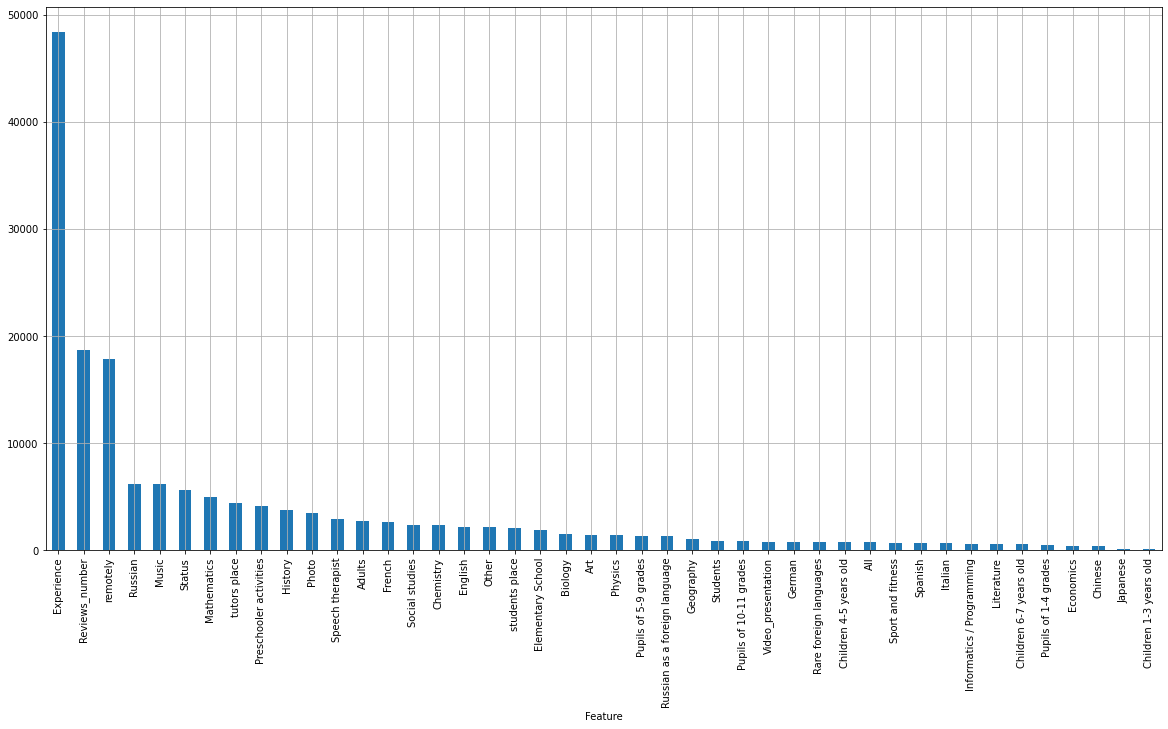

In [105]:
%%time
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

In [106]:
%%time
preds_3 = automl.predict(X_test)

CPU times: user 7.53 s, sys: 40.4 ms, total: 7.57 s
Wall time: 4.06 s


In [107]:
print("Mean Absolute Error: " + str(mean_absolute_error(preds_3.data.flatten(), y_test)))

Mean Absolute Error: 308.73878166323374


In [108]:
preds_3

array([[943.4431 ],
       [799.92914],
       [823.4127 ],
       ...,
       [750.21857],
       [854.96387],
       [697.0318 ]], dtype=float32)

Price estimations
---

In [109]:
data_for_predictions = pd.read_excel('data_for_predictions.xlsx', index_col=0)

Here we have tutor with 7 years of expirience, working as a university professor, who wants to teach independently pupils and students math, informatics/programming and physics. The tutor has just come to the site '[repetit.ru](https://repetit.ru)' and don't have any reviews. He just has photo in his profile, maybe some descriptions and doesn't want to create a video. The tutor prefers to work remotely

In [110]:
data_for_predictions

,Reviews_number,Experience,Status,Video_presentation,Photo,Art,Biology,Chemistry,Chinese,Economics,Elementary School,English,French,Geography,German,History,Informatics / Programming,Italian,Japanese,Literature,Mathematics,Music,Other,Physics,Preschooler activities,Rare foreign languages,Russian,Russian as a foreign language,Social studies,Spanish,Speech therapist,Sport and fitness,remotely,students place,tutors place,Adults,All,Children 1-3 years old,Children 4-5 years old,Children 6-7 years old,Pupils of 1-4 grades,Pupils of 10-11 grades,Pupils of 5-9 grades,Students
0,0,7,5,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1


In [111]:
pred_price = automl.predict(data_for_predictions)
pred_price

array([[908.8758]], dtype=float32)

Thus the start price for the tutor is  approximately 900 rub per hour. Taking into consideration that the MAE is approximately 300 rub we can apply 1200 rub per hour in the end